In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc
import pathlib
import os

import signac

from scipy import optimize

In [2]:
from monk import nb, prep, pair, render, utils, grid, workflow
import freud

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"].append(r'\usepackage{xfrac}')

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 2, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

0_375
0_450
0_525
0_600
0_675
0_750
0_825
0_900
0_975
1_050
1_125
1_200
1_275
1_350
1_425
1_500
[0.375, 0.45, 0.525, 0.6, 0.675, 0.75, 0.825, 0.9, 0.975, 1.05, 1.125, 1.2, 1.275, 1.35, 1.425, 1.5] [129.99999709427357, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291]
0_210
0_280
0_350
0_420
0_490
0_560
0_630
0_700
0_770
0_840
0_910
0_980
1_050
1_120
1_190
1_260
1_330
1_400
[0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7, 0.77, 0.84, 0.91, 0.98, 1.05, 1.12, 1.19, 1.26, 1.33, 1.4] [369.99999172985554, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241291, 49.99999888241

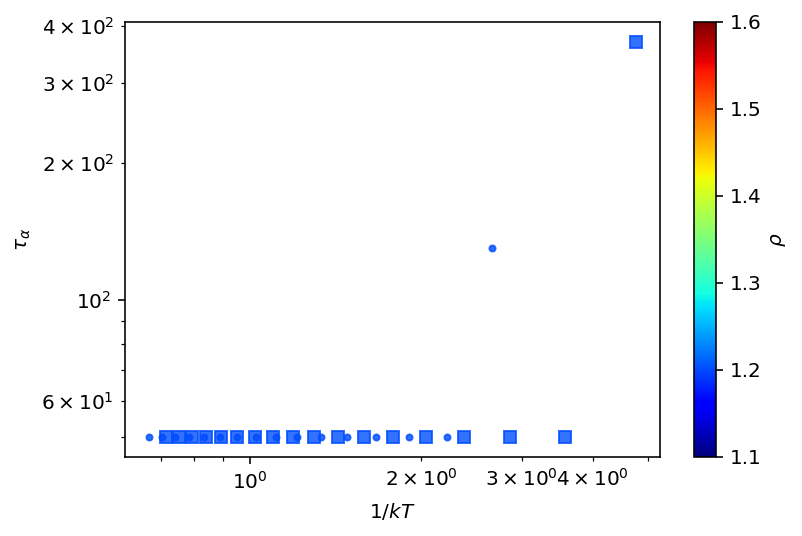

In [6]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s"}
cmap = cm.jet
norm = colors.Normalize(vmin=1.1, vmax=1.6)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("quench/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                # print(list(job.data["quench"].keys()))
                print(_temp_str)
                # try:
                if len(job.data[f"quench/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"quench/temp_{_temp_str}/alphas"][-5:])
                # if alpha < 11:
                #     continue
                D = np.mean(job.data[f"quench/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        print(temps, alphas)
        plt.plot(1/np.array(temps), np.array(alphas), marker, color=col, alpha=_alpha)

plt.xlabel(r"$1/kT$")
plt.ylabel(r"$\tau_{\alpha}$")
plt.yscale('log')
plt.xscale('log')
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

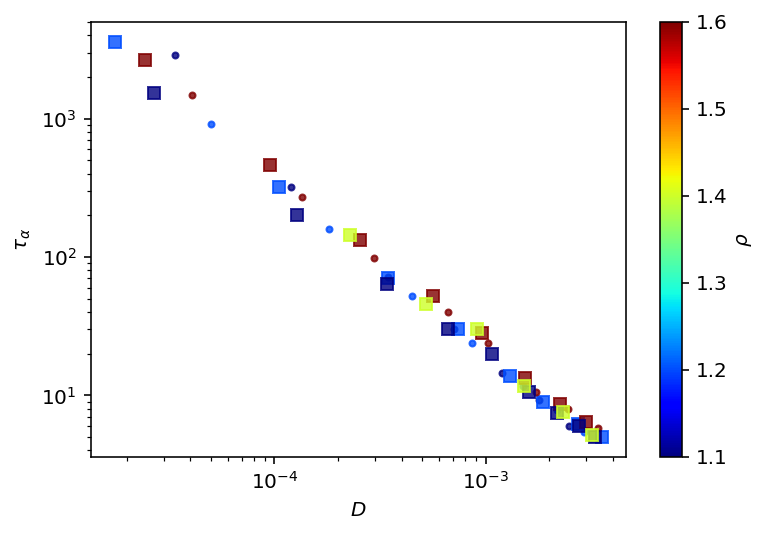

In [30]:

plt.figure()

_alpha = .8

markers = {"KA_LJ": ".", "KA_WCA": "s"}
cmap = cm.jet
norm = colors.Normalize(vmin=1.1, vmax=1.6)

for i, job in enumerate(project):

    # delta = job.sp["delta"]
    # if delta > 0.45:
    #     continue

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                # print(list(job.data["fine"].keys()))
                # print(_temp_str)
                # try:
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 5:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # except:
                #     raise ValueError("No data found")
                
        # print(temps, alphas)
        plt.plot(np.array(Ds), np.array(alphas), marker, color=col, alpha=_alpha)

plt.ylabel(r"$\tau_{\alpha}$")
plt.xlabel(r"$D$")
# plt.legend(title=r"$\Delta$", handles=_legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")
plt.yscale('log')
plt.xscale('log')

0.275 2860.0001358427107
0.300 320.0000151991844
0.325 72.0000034198165
0.350 30.00000142492354
0.375 14.400000683963299
0.400 9.200000436976552
0.425 6.000000284984708
0.450 920.0000436976552
0.488 160.0000075995922
0.525 52.00000246986747
0.563 24.00000113993883
0.600 11.600000550970435
0.638 7.80000037048012
0.675 5.400000256486237
0.280 3600.0001709908247
0.315 318.0000151041895
0.350 70.00000332482159
0.385 30.00000142492354
0.420 13.800000655464828
0.455 9.000000427477062
0.490 6.200000294484198
0.525 5.0000002374872565
1.700 2640.0001253932714
1.800 460.0000218488276
1.900 132.00000626966357
2.000 52.00000246986747
2.100 28.000001329928637
2.200 13.400000636465847
2.300 8.600000408478081
2.400 6.400000303983688
1.800 1480.000070296228
1.900 272.00001291930676
2.000 98.00000465475023
2.100 40.00000189989805
2.200 24.00000113993883
2.300 10.600000503472984
2.400 8.00000037997961
2.500 5.800000275485218
0.120 1540.000073146075
0.140 200.00000949949026
0.160 64.00000303983688
0.180 

Text(0, 0.5, '$\\tau_{\\alpha}$')

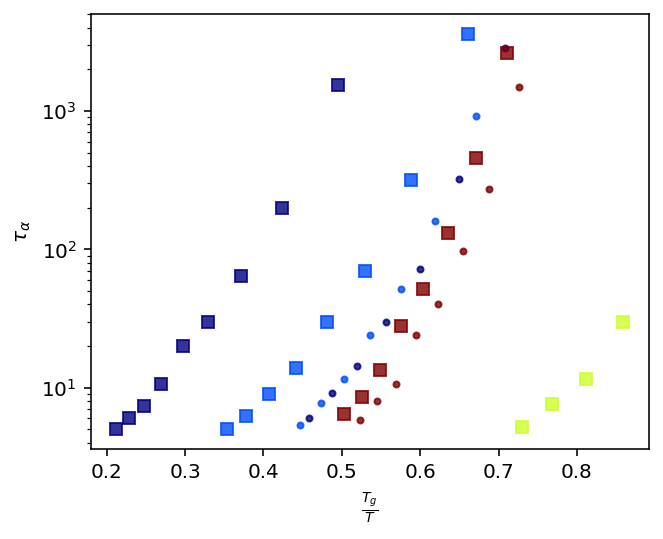

In [18]:
def vft(x, a, b, t):
    return np.log(a * np.exp(b/(x-t)))

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-5:])
                if alpha < 5:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-5:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = popt[2]
        # tg = np.min(temps)/2
        # print(popt, pcov)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

In [1]:
def vft(x, a, b, t):
    return np.log(a * np.exp(b/(x-t)))

plt.figure(figsize=(5,4))

for i, job in enumerate(project):

    marker = markers[job.sp["pot"]]
    col = cmap(norm(job.sp["rho"]))

    with job:
        sims = sorted(glob.glob("fine/equil_*.gsd"))
        temps = []
        alphas = []
        Ds = []
        for sim in sims:
            temp_str = utils.extract_between(sim, "equil_temp-", ".gsd")

            with job.data:
                _temp_str = temp_str.replace(".", "_")
                if len(job.data[f"fine/temp_{_temp_str}/alphas"]) == 0:
                    continue
                alpha = np.mean(job.data[f"fine/temp_{_temp_str}/alphas"][-4:])
                if alpha < 2:
                    continue
                D = np.mean(job.data[f"fine/temp_{_temp_str}/Ds"][-4:])
                alphas.append(alpha)
                Ds.append(D)
                temps.append(float(temp_str))
                # print(temp_str, alpha)
        
        if len(alphas) == 0:
            continue
        # print(temps, alphas)
        print(np.max(alphas))
        alphas = np.log(np.array(alphas))
        temps = np.array(temps)
        popt, pcov = optimize.curve_fit(vft, temps, alphas, p0=(1, 0.5, np.min(temps)/2), bounds=([0, -0, np.min(temps)/4], [np.inf, np.inf, np.min(temps)]))
        tg = popt[2]
        # tg = np.min(temps)/2
        # print(popt, pcov)
        x = np.linspace(tg*1.3, tg*10.0, 100)
        y = vft(x, *popt)
        print(tg)
        plt.plot(tg/x, np.exp(y), "--", color=col, alpha=_alpha)
        plt.plot(tg/temps, np.exp(alphas) , marker, color=col, alpha=_alpha)

plt.yscale("log")
plt.xlabel(r"$\frac{T_g}{T}$")
plt.ylabel(r"$\tau_{\alpha}$")

lines = [
    plt.Line2D([0], [0], color='black', lw=0, marker="."),
    plt.Line2D([0], [0], color='black', lw=0, marker="s"),
]
plt.legend(lines, ["LJ", "WCA"], loc="best")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")

plt.ylim(1e0, 1e4)
plt.xlim(0.1, 0.8)

NameError: name 'plt' is not defined